In [1]:
import numpy as np
import tensorflow as tf
from src.util import plot_voxel, plot_voxel_c, plot_reconstruction_set

# import vae
from src.vae import vae_model
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2024-05-28 07:38:06.182638: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Stage 3

_Build the full reconstruction network architecture_

1. Load the VAE $\Psi : \mathbf{z} \mapsto \hat{\gamma}$
2. Load the mapper $\Xi : \mathbf{u} \mapsto \mathbf{z}$
3. Load the material classificator $\Upsilon : \mathbf{u} \mapsto \mathbf{m}$

The final model is described by:

$$\Gamma := \Xi \circ \Psi : \mathbf{u} \mapsto \mathbf{z} \mapsto \hat{\gamma} $$

with the material classification model:

$$\Upsilon : \mathbf{u} \mapsto \mathbf{m} $$

## *i)* Load the VAE

In [2]:
vae = vae_model()
vae.load_weights("models/vaes/vae_21.weights.h5")  # select VAE 21
vae.summary()

Φ = vae.encoder
Ψ = vae.decoder

2024-05-28 07:38:13.439780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45560 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ VAE_encoder (Functional)        │ ?                      │        13,662 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VAE_decoder (Functional)        │ ?                      │        17,933 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,595 (123.42 KB)

 Trainable params: 31,533 (123.18 KB)

 Non-trainable params: 62 (248.00 B)

In [3]:
tmp = np.load("models/testdata_stage3.npz", allow_pickle=True)
X_test, gamma_test, m_test = (
    tmp["X_test"],
    tmp["gamma_test"],
    tmp["m_test"],
)
print(X_test.shape, gamma_test.shape, m_test.shape)

(12420, 64, 64, 1) (12420, 32, 32, 32, 1) (12420,)


In [4]:
_, _, z_pred = Φ.predict(gamma_test)
γ_pred = Ψ.predict(z_pred)

I0000 00:00:1716881900.849878 3883871 service.cc:145] XLA service 0x7fc44c04afa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716881900.849928 3883871 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-05-28 07:38:20.887836: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-28 07:38:21.145028: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 58/389 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

I0000 00:00:1716881901.745168 3883871 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


389/389 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


True γ distribution


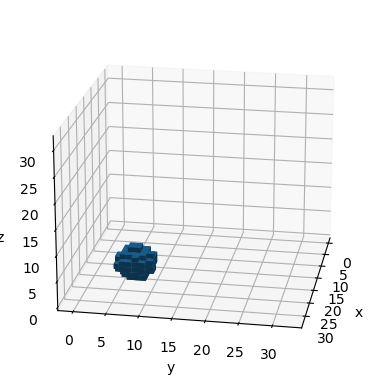

Predicted γ distribution


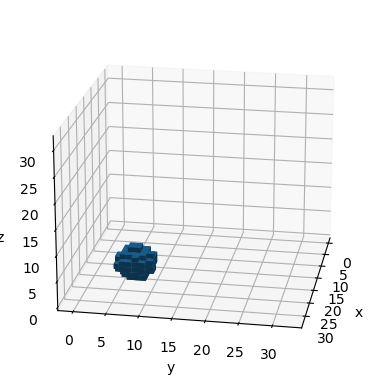

----------
True γ distribution


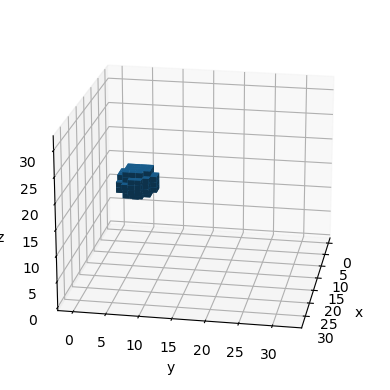

Predicted γ distribution


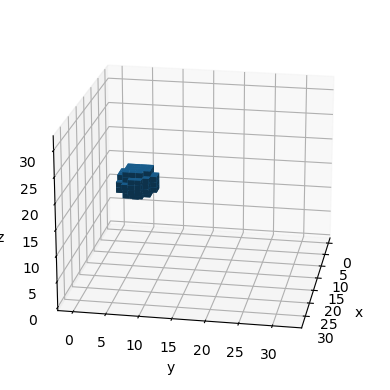

----------
True γ distribution


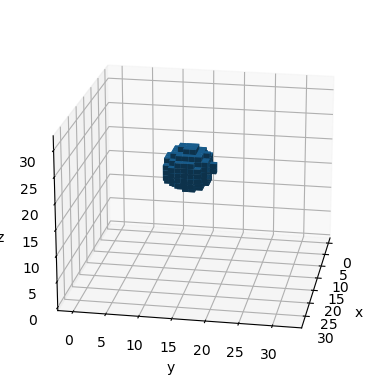

Predicted γ distribution


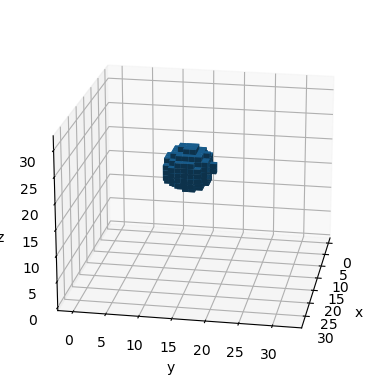

----------
True γ distribution


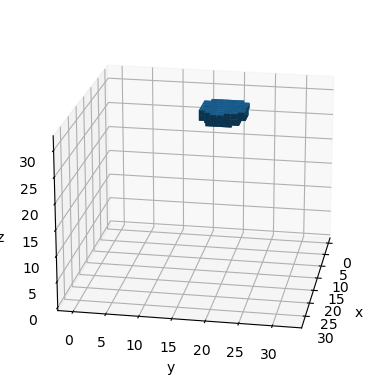

Predicted γ distribution


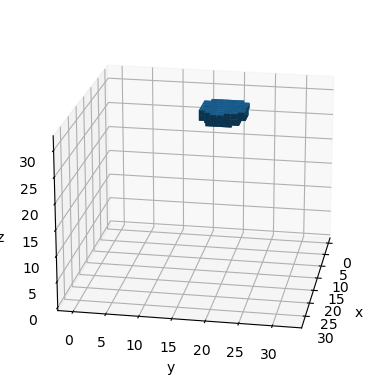

----------
True γ distribution


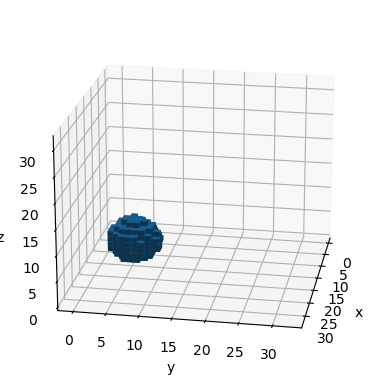

Predicted γ distribution


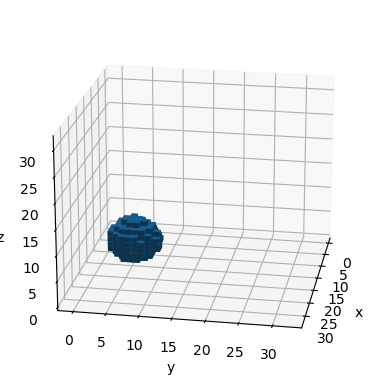

----------


In [5]:
for rdn in np.random.randint(low=0, high=X_test.shape[0], size=5):
    print("True γ distribution")
    plot_voxel(gamma_test[rdn, :, :, :, 0])
    sgl_pred = np.squeeze(gamma_test, axis=4)[rdn]
    sgl_pred = np.clip(sgl_pred, a_min=0, a_max=1)
    print("Predicted γ distribution")
    plot_voxel(sgl_pred)
    print("----------")

## *ii)* Load the material classification network $\Upsilon$ and the Mapper $\Xi$ 

In [6]:
def Upsilon_model(input_shape=(64, 64, 1), latent_dim=1, kernel=3):
    mapper_input = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(mapper_input)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Flatten()(x)
    mapper_output = tf.keras.layers.Dense(latent_dim, activation="linear")(x)
    return tf.keras.Model(mapper_input, mapper_output)


Y = Upsilon_model()
Y.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 16, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 4, 8)       │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 1, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 1, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,217 (16.47 KB)

 Trainable params: 4,217 (16.47 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
Y.load_weights("models/material_mapper.weights.h5")

In [8]:
def mapper_CNN(input_shape=(64, 64, 1), latent_dim=8):

    filters = [4, 8, 16, 32]
    kernels = [(4, 4) for _ in range(4)]
    strides = [(1, 1) for _ in range(4)]
    pools = [(2, 2) for _ in range(4)]

    print(f"{filters=}, kernels{kernels[0]}, strides={strides[0]}, pools={pools[0]}")

    x = tf.keras.layers.Input(shape=input_shape)
    mapper_input = x

    for f, k, s, p in zip(filters, kernels, strides, pools):
        x = tf.keras.layers.Conv2D(
            filters=f, kernel_size=k, strides=s, padding="valid", activation="relu"
        )(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=p)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(latent_dim, activation="relu")(x)
    mapper_output = tf.keras.layers.Dense(latent_dim)(x)

    return tf.keras.Model(mapper_input, mapper_output)


Ξ = mapper_CNN()
# Ξ.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
Ξ.summary()

filters=[4, 8, 16, 32], kernels(4, 4), strides=(1, 1), pools=(2, 2)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 4)      │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 27, 27, 8)      │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 32)       │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            72 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,212 (43.80 KB)

 Trainable params: 11,212 (43.80 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
Ξ.load_weights("models/mappers/mapper_8.weights.h5")

## *iii)* Setup the final reconstruction network

In [10]:
gamma_test = np.squeeze(gamma_test, axis=4)

In [11]:
γ_hat = Ψ.predict(Ξ.predict(X_test))
γ_hat = np.squeeze(γ_hat, axis=4)
γ_hat = np.clip(γ_hat, a_min=0, a_max=1)
γ_hat[γ_hat != 0] = 1
print(γ_hat.shape)

m_pred = np.round(Y.predict(X_test))

389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(12420, 32, 32, 32)
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Selcted the samples = [1891, 3800, 1534, 7498, 7733]
Row 0 -> true γ distribution
Row 1 -> pred γ distribution


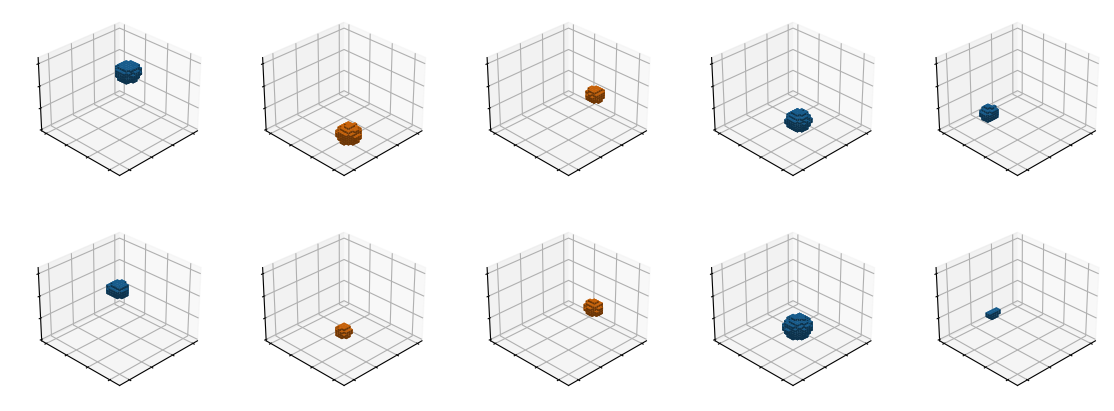

In [21]:
plot_reconstruction_set(
    gamma_test,
    m_test,
    γ_hat,
    m_pred,
    save_fig="images/predicted_test_data_results.pdf",
    forced_sel=[1891, 3800, 1534, 7498, 7733],
)